In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession

In [3]:
spark=SparkSession.builder.appName('Tip1').getOrCreate()

In [4]:
dc=spark.read.csv('d:\\credit.csv',header=True,inferSchema=True)
dc.limit(6).toPandas()

,CUSTID,BALANCE,BALANCEFREQUENCY,PURCHASES,ONEOFFPURCHASES,INSTALLMENTSPURCHASES,CASHADVANCE,PURCHASESFREQUENCY,ONEOFFPURCHASESFREQUENCY,PURCHASESINSTALLMENTSFREQUENCY,CASHADVANCEFREQUENCY,CASHADVANCETRX,PURCHASESTRX,CREDITLIMIT,PAYMENTS,MINIMUMPAYMENTS,PRCFULLPAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.00,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.000000,0,8,1800.0,1400.057770,2407.246035,0.000000,12


In [6]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

def null_value_calc(df):
    null_columns_counts = []
    numRows = df.count()
    for k in df.columns:
        nullRows = df.where(col(k).isNull()).count()
        if(nullRows > 0):
            temp = k,nullRows,(nullRows/numRows)*100
            null_columns_counts.append(temp)
    return(null_columns_counts)

null_columns_calc_list = null_value_calc(dc)
print("Null COlumns calc list " ,null_columns_calc_list)
#schema = StructType([StructField("M1", IntegerType(), True),StructField("M2", IntegerType(), True),StructField("M3", IntegerType(), True)])
#spark.createDataFrame(data=[(5,6,7),(5,6,7)],schema=schema).show()
spark.createDataFrame(null_columns_calc_list, ['Column_Name', 'Null_Values_Count','Null_Value_Percent']).show()

Null COlumns calc list  [('CREDITLIMIT', 1, 0.0111731843575419), ('MINIMUMPAYMENTS', 313, 3.4972067039106145)]
+---------------+-----------------+------------------+
|    Column_Name|Null_Values_Count|Null_Value_Percent|
+---------------+-----------------+------------------+
|    CREDITLIMIT|                1|0.0111731843575419|
|MINIMUMPAYMENTS|              313|3.4972067039106145|
+---------------+-----------------+------------------+



In [14]:
from pyspark.sql.functions import *
def fill_with_mean(dc, include=set()): 
    stats=dc.agg(*(avg(c).alias(c) for c in dc.columns if c in include)) 
    return dc.na.fill(stats.first().asDict())

columns= dc.columns
columns= columns[1:]
dc= fill_with_mean(dc, columns)

dc.limit(5).toPandas()

,CUSTID,BALANCE,BALANCEFREQUENCY,PURCHASES,ONEOFFPURCHASES,INSTALLMENTSPURCHASES,CASHADVANCE,PURCHASESFREQUENCY,ONEOFFPURCHASESFREQUENCY,PURCHASESINSTALLMENTSFREQUENCY,CASHADVANCEFREQUENCY,CASHADVANCETRX,PURCHASESTRX,CREDITLIMIT,PAYMENTS,MINIMUMPAYMENTS,PRCFULLPAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [15]:
from pyspark.ml.feature import VectorAssembler
input_columns=dc.columns
input_columns=input_columns[1:]
vecAssembler=VectorAssembler(inputCols=input_columns,outputCol="features")
dc_kmeans=vecAssembler.transform(dc)
dc_kmeans.limit(4).toPandas()

,CUSTID,BALANCE,BALANCEFREQUENCY,PURCHASES,ONEOFFPURCHASES,INSTALLMENTSPURCHASES,CASHADVANCE,PURCHASESFREQUENCY,ONEOFFPURCHASESFREQUENCY,PURCHASESINSTALLMENTSFREQUENCY,CASHADVANCEFREQUENCY,CASHADVANCETRX,PURCHASESTRX,CREDITLIMIT,PAYMENTS,MINIMUMPAYMENTS,PRCFULLPAYMENT,TENURE,features
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,"[40.900749, 0.818182, 95.4, 0.0, 95.4, 0.0, 0...."
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,"(3202.467416, 0.909091, 0.0, 0.0, 0.0, 6442.94..."
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,"[2495.148862, 1.0, 773.17, 773.17, 0.0, 0.0, 1..."
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,"[1666.670542, 0.636364, 1499.0, 1499.0, 0.0, 2..."


In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np
kmax=50
kmcost=np.zeros(kmax)
print(kmcost)
for k in range(2,kmax):
    kmeans=KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model=kmeans.fit(dc_kmeans)
    print('______________')
    print(kmcost)
    predictions=model.transform(dc_kmeans)
    evaluator=ClusteringEvaluator()
    kmcost[k]=evaluator.evaluate(predictions)
print(predictions)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
______________
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
______________
[0.         0.         0.64986787 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
______________
[0.         0.         0.64986787 0.62098611 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        

______________
[0.         0.         0.64986787 0.62098611 0.55172965 0.58251814
 0.515094   0.47754444 0.4822174  0.49507616 0.50741943 0.51722156
 0.50921003 0.44683201 0.43387232 0.5144033  0.360223   0.36859372
 0.37833852 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
______________
[0.         0.         0.64986787 0.62098611 0.55172965 0.58251814
 0.515094   0.47754444 0.4822174  0.49507616 0.50741943 0.51722156
 0.50921003 0.44683201 0.43387232 0.5144033  0.360223   0.36859372
 0.37833852 0.36822021 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0

______________
[0.         0.         0.64986787 0.62098611 0.55172965 0.58251814
 0.515094   0.47754444 0.4822174  0.49507616 0.50741943 0.51722156
 0.50921003 0.44683201 0.43387232 0.5144033  0.360223   0.36859372
 0.37833852 0.36822021 0.37162847 0.34229368 0.40416505 0.36596995
 0.35805194 0.38165996 0.37085142 0.37215223 0.36243063 0.29233614
 0.30419694 0.3122535  0.30482705 0.29445893 0.29286027 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
______________
[0.         0.         0.64986787 0.62098611 0.55172965 0.58251814
 0.515094   0.47754444 0.4822174  0.49507616 0.50741943 0.51722156
 0.50921003 0.44683201 0.43387232 0.5144033  0.360223   0.36859372
 0.37833852 0.36822021 0.37162847 0.34229368 0.40416505 0.36596995
 0.35805194 0.38165996 0.37085142 0.37215223 0.36243063 0.29233614
 0.30419694 0.3122535  0.30482705 0.29445893 0.29286027 0.36221758
 0.         0.         0.       

DataFrame[CUSTID: string, BALANCE: double, BALANCEFREQUENCY: double, PURCHASES: double, ONEOFFPURCHASES: double, INSTALLMENTSPURCHASES: double, CASHADVANCE: double, PURCHASESFREQUENCY: double, ONEOFFPURCHASESFREQUENCY: double, PURCHASESINSTALLMENTSFREQUENCY: double, CASHADVANCEFREQUENCY: double, CASHADVANCETRX: int, PURCHASESTRX: int, CREDITLIMIT: double, PAYMENTS: double, MINIMUMPAYMENTS: double, PRCFULLPAYMENT: double, TENURE: int, features: vector, prediction: int]


Text(0, 0.5, 'cost')

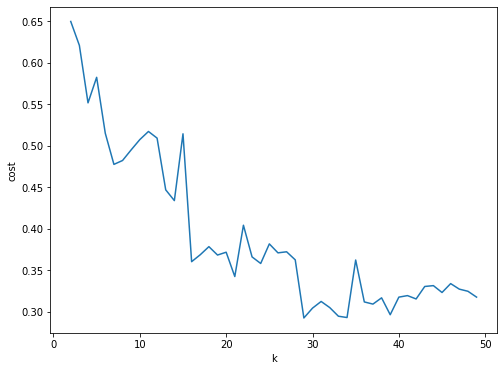

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.plot(range(2,kmax),kmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [21]:
from pyspark.ml.clustering import BisectingKMeans
kmax=50
bkmcost=np.zeros(kmax)
for k in range(2,kmax):
    bkmeans=BisectingKMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model=bkmeans.fit(dc_kmeans)
 
    predictions=model.transform(dc_kmeans)
    evaluator=ClusteringEvaluator()
    kmcost[k]=evaluator.evaluate(predictions)


Text(0, 0.5, 'cost')

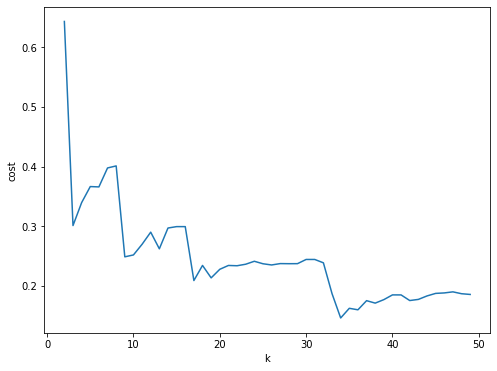

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.plot(range(2,kmax),kmcost[2:kmax])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
dti=